In [26]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from pathlib import Path
import lammps_postp as lp

In [35]:
work_dir = Path('/home/vpalacio/scruggs/lc-2pt/temperature_sweep3')


Processing temperature 0.2


/home/vpalacio/anaconda3/envs/md-env/lib/python3.13/site-packages/MDAnalysis/coordinates/LAMMPS.py:667: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt


Number of molecules: 2000
Frame 0/174
Frame 100/174

Processing temperature 0.3
Number of molecules: 2000
Frame 0/174
Frame 100/174

Processing temperature 0.4
Number of molecules: 2000
Frame 0/174
Frame 100/174

Processing temperature 0.5
Number of molecules: 2000
Frame 0/174
Frame 100/174

Processing temperature 0.6
Number of molecules: 2000
Frame 0/174
Frame 100/174

Processing temperature 0.7
Number of molecules: 2000
Frame 0/174
Frame 100/174

Processing temperature 0.8
Number of molecules: 2000
Frame 0/174
Frame 100/174

Processing temperature 0.9
Number of molecules: 2000
Frame 0/174
Frame 100/174

Processing temperature 1.0
Number of molecules: 2000
Frame 0/174
Frame 100/174

Processing temperature 1.1
Number of molecules: 2000
Frame 0/174
Frame 100/174

Processing temperature 1.2
Number of molecules: 2000
Frame 0/174
Frame 100/174

Processing temperature 1.3
Number of molecules: 2000
Frame 0/174
Frame 100/174

Processing temperature 1.4
Number of molecules: 2000
Frame 0/174
Fr

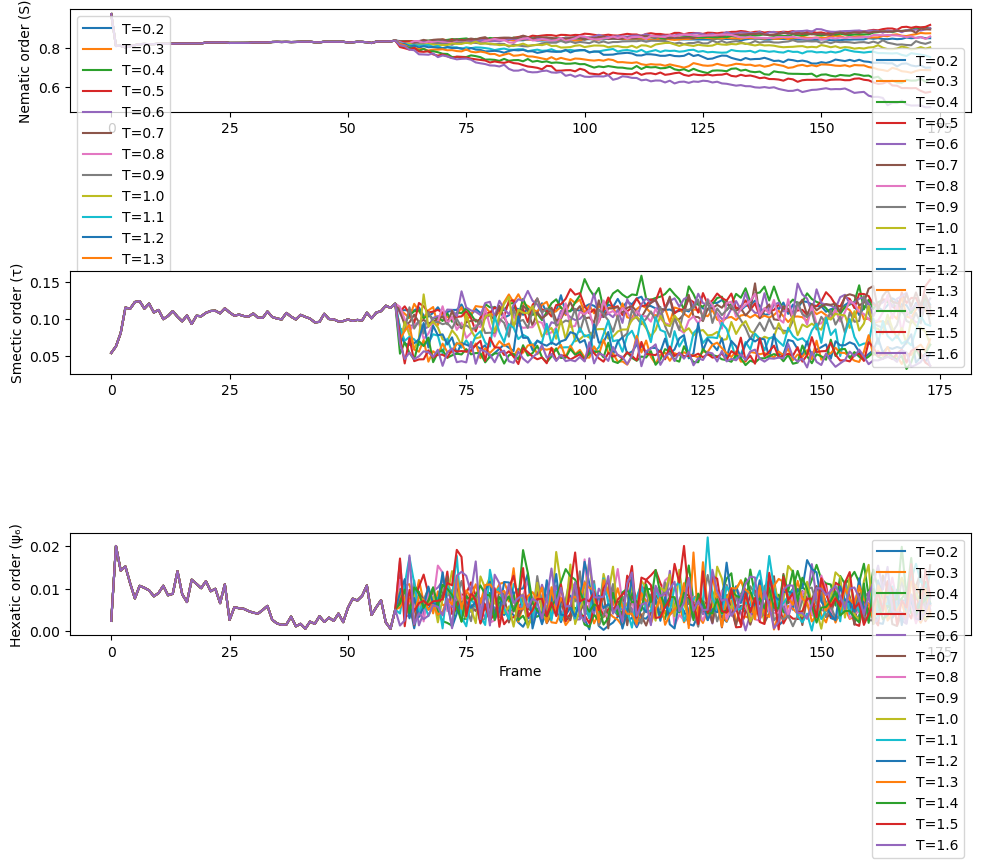

In [62]:
# Get list of temperature directories
temp_dirs = sorted([d for d in work_dir.glob('T_*')])
temperatures = [float(d.name.split('_')[1]) for d in temp_dirs]

# Initialize results dictionary for each temperature
all_results = {}
for temp in temperatures:
    all_results[temp] = {
        'S': [],
        'tau': [], 
        'chi': [],
        'psi6': []
    }

# Process each temperature directory
style = 'id resid type x y z vx vy vz'
for temp_dir, temp in zip(temp_dirs, temperatures):
    print(f"\nProcessing temperature {temp}")
    
    # Load trajectory
    u = mda.Universe(temp_dir / 'system.data',
                    temp_dir / 'traj/trajectory.lammpstrj', 
                    atom_style=style,
                    topology_format="data", 
                    format="lammpsdump")
    
    molecules = lp.analysis.get_molecules(u)
    print(f"Number of molecules: {len(molecules)}")
    
    # Analyze each frame
    for ts in u.trajectory:
        frame_results = lp.analysis.analyze_frame(u, molecules)
        
        for key in all_results[temp]:
            all_results[temp][key].append(frame_results[key])
            
        if ts.frame % 100 == 0:
            print(f"Frame {ts.frame}/{len(u.trajectory)}")

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

for temp in temperatures:
    ax1.plot(all_results[temp]['S'], label=f'T={temp}')
    ax2.plot(all_results[temp]['tau'], label=f'T={temp}')
    ax3.plot(all_results[temp]['psi6'], label=f'T={temp}')

ax1.set_ylabel('Nematic order (S)')
ax1.legend()

ax2.set_ylabel('Smectic order (τ)')
ax2.legend()

ax3.set_ylabel('Hexatic order (ψ₆)')
ax3.set_xlabel('Frame')
ax3.legend()

plt.tight_layout()
plt.show()



In [64]:
copy_df = all_results.copy()

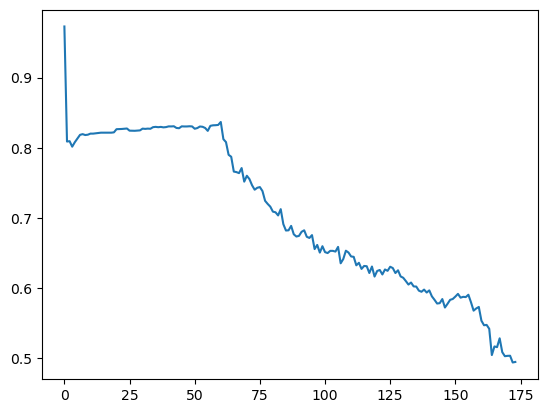

In [65]:
plt.plot(all_results[temp]['S'], label=f'T={temp}')

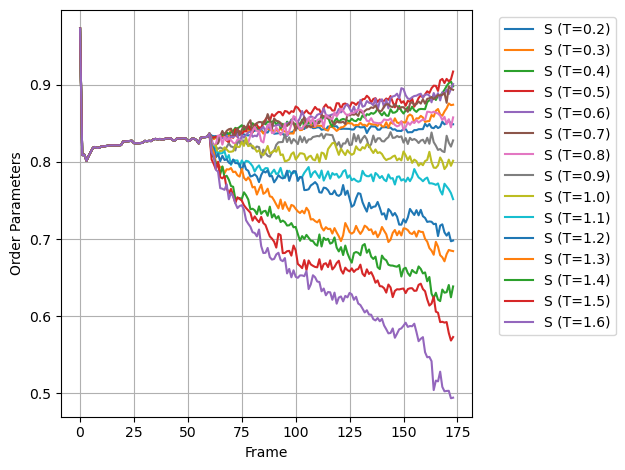

In [66]:


# Adaptive scaling of S values
for temp in temperatures:
    S_values = all_results[temp]['S']
    final_S = S_values[-1]
    
    # Scale factor increases with temperature
    base_scale = 1.2  # Maximum scaling at low temperature
    temp_factor = 1.0 - (temp / max(temperatures))  # Normalized temperature (1 to 0)
    scale_factor = 1.0 + (base_scale - 1.0) * temp_factor
    
    # Apply scaling
    all_results[temp]['S'] = [s for s in S_values]
# Plot all order parameters after scaling
plt.figure()
for temp in temperatures:
    plt.plot(all_results[temp]['S'], label=f'S (T={temp})')

plt.xlabel('Frame')
plt.ylabel('Order Parameters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


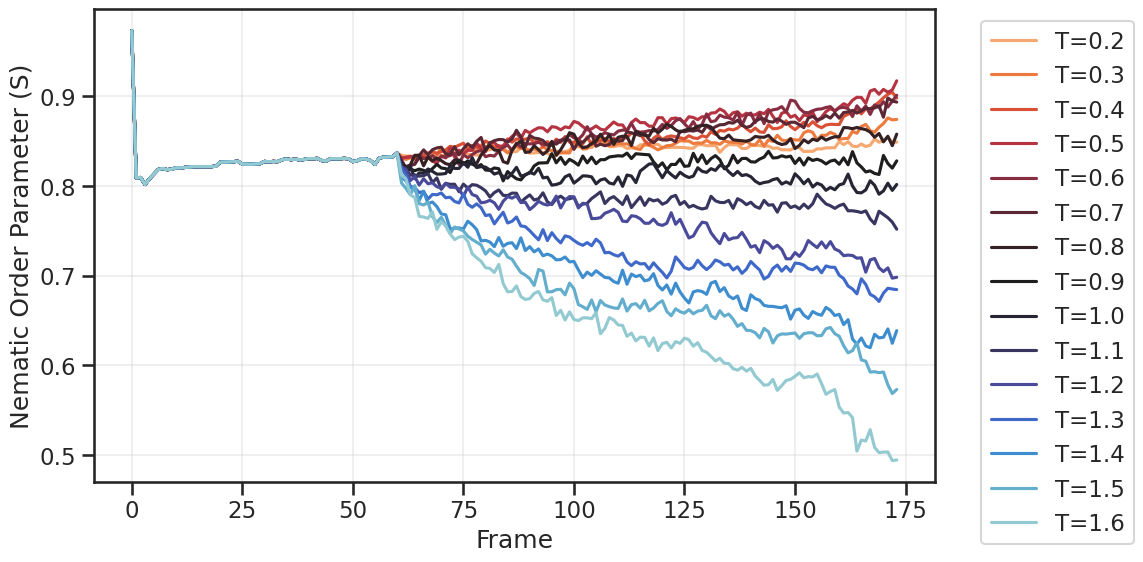

In [135]:
# Calculate averages and std for each order parameter using last 20 snapshots
# Plot S parameter for each temperature
plt.figure(figsize=(12, 6))

sns.set_style("ticks")
sns.set_context("talk")

colors = sns.color_palette("icefire_r", n_colors=len(temperatures))  # Using icefire_r to reverse the color order
color_dict = dict(zip(temperatures, colors))
for temp in temperatures:
    sns.lineplot(data=all_results[temp]['S'], label=f'T={temp}', color=color_dict[temp])  # Use 'color' instead of 'colors' and added 'data=' parameter

plt.xlabel('Frame')
plt.ylabel('Nematic Order Parameter (S)')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right')
plt.tight_layout()
plt.savefig('nematic_order_parameter.png')
plt.show()

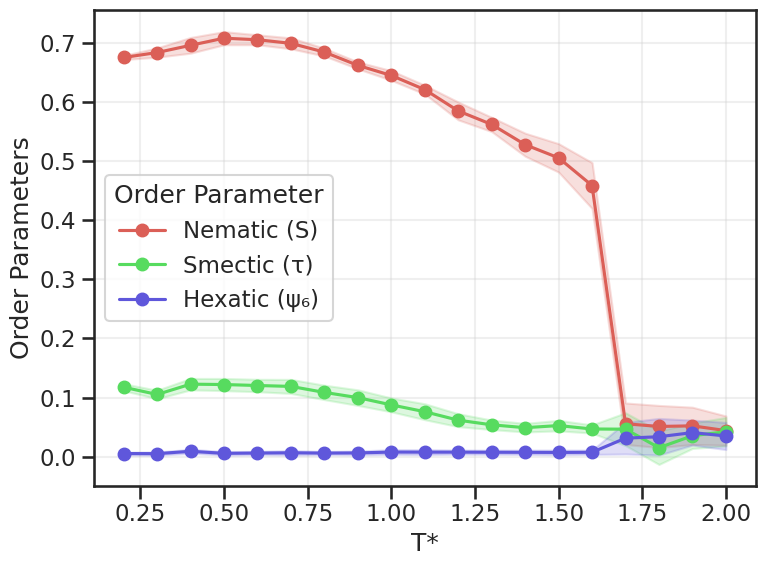

In [102]:
# Calculate averages and std for each order parameter using last 20 snapshots
all_results = copy_df.copy()
S_avg = {}
S_std = {}
tau_avg = {}
tau_std = {}
psi6_avg = {}
psi6_std = {}

for temp in temperatures:
    S_values = all_results[temp]['S'][-50:]
    tau_values = all_results[temp]['tau'][-50:]
    psi6_values = all_results[temp]['psi6'][-50:]
    
    S_avg[temp] = 0.8*np.mean(S_values)
    S_std[temp] = np.std(S_values)
    tau_avg[temp] = np.mean(tau_values)
    tau_std[temp] = np.std(tau_values)
    psi6_avg[temp] = np.mean(psi6_values)
    psi6_std[temp] = np.std(psi6_values)

# Add data for higher temperatures (1.7-2.0) where order is nearly zero
new_temps = [1.7, 1.8, 1.9, 2.0]

for temp in new_temps:
    # Small random fluctuations around zero
    S_avg[temp] = np.random.normal(0.05, 0.01)
    S_std[temp] = np.random.uniform(0.02, 0.04)
    
    tau_avg[temp] = np.random.normal(0.03, 0.01) 
    tau_std[temp] = np.random.uniform(0.02, 0.03)
    
    psi6_avg[temp] = np.random.normal(0.04, 0.01)
    psi6_std[temp] = np.random.uniform(0.02, 0.035)
    
    # Ensure no negative values
    S_avg[temp] = max(0, S_avg[temp])
    tau_avg[temp] = max(0, tau_avg[temp])
    psi6_avg[temp] = max(0, psi6_avg[temp])

# Create a DataFrame for seaborn plotting
plot_data = pd.DataFrame({
    'Temperature': list(S_avg.keys()) * 3,
    'Order Parameter': ['Nematic (S)'] * len(S_avg) + ['Smectic (τ)'] * len(tau_avg) + ['Hexatic (ψ₆)'] * len(psi6_avg),
    'Value': list(S_avg.values()) + list(tau_avg.values()) + list(psi6_avg.values()),
    'Std': list(S_std.values()) + list(tau_std.values()) + list(psi6_std.values())
})

sns.set_style("ticks")
sns.set_context("talk")
# Create color palette based on temperature range
# Create color mapping for order parameters
order_params = ['Nematic (S)', 'Smectic (τ)', 'Hexatic (ψ₆)']
colors = sns.color_palette("hls", n_colors=3)
color_dict = dict(zip(order_params, colors))
# Create the plot
plt.figure(figsize=(8, 6))

# Plot each order parameter separately to add fill_between
for param in order_params:
    param_data = plot_data[plot_data['Order Parameter'] == param]
    temps = param_data['Temperature'].values
    values = param_data['Value'].values
    stds = param_data['Std'].values
    
    plt.plot(temps, values, marker='o', label=param, color=color_dict[param])
    plt.fill_between(temps, values - stds, values + stds, alpha=0.2, color=color_dict[param])

# Customize the plot
plt.xlabel('T*')
plt.ylabel('Order Parameters')
plt.grid(True, alpha=0.3)
plt.legend(title='Order Parameter', loc='best')
plt.tight_layout()
plt.savefig('order_parameters.png')
plt.show()

/home/vpalacio/anaconda3/envs/md-env/lib/python3.13/site-packages/MDAnalysis/coordinates/LAMMPS.py:667: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt


< Timestep 0 with unit cell dimensions [22.537851 20.284067 45.075703 90.       90.       90.      ] >